<a href="https://colab.research.google.com/github/m-wessler/gefs-ai-ml/blob/main/XGBoost_Machine_Learning_Regression_Training_(T4_GPU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from datetime import datetime

from sklearn.model_selection import train_test_split

In [ ]:
# Configuration
STATION_ID = "KSLC" # Change as needed
CSV_PATH = "/content/KBOI_2000_2009_f024.reforecast.csv" # Path to your data (ensure this exists)
TARGET_VARIABLE = "tmax_obs"
PREDICTOR = "tmax_2m" # Minimal: just use tmax_2m as predictor (change as needed)

EXCLUDE_VARS = ['tmin_obs', 'hgt_ceiling', 'gust_sfc', 'cape_sfc', 'cin_sfc', 'tmin_2m']  # ["tmp_2m", "tmax_2m"]

INCLUDE_VARS = [
    "hgt_pres_850", "hgt_pres_925", "tmp_pres_700", "tmp_pres_850",
    "tmp_pres_925", "ugrd_pres_850", "ugrd_pres_925", "vgrd_pres_850",
    "vgrd_pres_925", "hgt_pres_700", "ugrd_pres_700", "vgrd_pres_700",
    "cape_sfc", "cin_sfc", "dlwrf_sfc", "dswrf_sfc", "gust_sfc",
    "hgt_ceiling", "lhtfl_sfc", "pres_sfc", "pres_msl", "shtfl_sfc",
    "soilw_bgrnd", "tcdc_eatm", "tmax_2m", "tmin_2m", "tmp_2m",
    "ulwrf_sfc", "uswrf_sfc", "ugrd_hgt", "vgrd_hgt"
]

# AFILE VARS   ["pres_msl", "pres_sfc", "hgt_pres", "tmp_2m", "tmp_pres", "tmin_2m", "tmax_2m", "ugrd_hgt",
#               "ugrd_pres", "vgrd_hgt", "vgrd_pres", "dswrf_sfc", "dlwrf_sfc", "uswrf_sfc", "ulwrf_sfc",
#               "lhtfl_sfc", "shtfl_sfc", "soil_bgrnd", "tcdc_eatm"]

In [ ]:
# Load data
df = pd.read_csv(CSV_PATH)

df['valid_datetime'] = df['valid_datetime'].astype('datetime64[ns]')
df['doy'] = df['valid_datetime'].dt.dayofyear

keep_cols = [c for c in df.columns if (any(var in c for var in INCLUDE_VARS)
                and not any(var in c for var in EXCLUDE_VARS))]

[keep_cols.append(c) for c in ["valid_datetime", "doy", TARGET_VARIABLE]]

df = df[keep_cols]
df.set_index("valid_datetime", inplace=True)

print(df.columns)

df.dropna(how='any', inplace=True)
X = df.drop(columns=[TARGET_VARIABLE])
y = df[TARGET_VARIABLE]

# First split: train+val and test (e.g., 70% train+val, 30% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split: train and val (e.g., from 70% train+val, take 70% train, 30% val ⇒ 49% train, 21% val overall)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

df

Index(['pres_msl', 'pres_sfc', 'hgt_pres_925', 'hgt_pres_850', 'hgt_pres_700',
       'tmp_2m', 'tmp_pres_925', 'tmp_pres_850', 'tmp_pres_700', 'tmax_2m',
       'ugrd_hgt', 'ugrd_pres_925', 'ugrd_pres_850', 'ugrd_pres_700',
       'vgrd_hgt', 'vgrd_pres_925', 'vgrd_pres_850', 'vgrd_pres_700',
       'dswrf_sfc', 'dlwrf_sfc', 'uswrf_sfc', 'ulwrf_sfc', 'lhtfl_sfc',
       'shtfl_sfc', 'soilw_bgrnd', 'tcdc_eatm', 'doy', 'tmax_obs'],
      dtype='object')


,pres_msl,pres_sfc,hgt_pres_925,hgt_pres_850,hgt_pres_700,tmp_2m,tmp_pres_925,tmp_pres_850,tmp_pres_700,tmax_2m,...,dswrf_sfc,dlwrf_sfc,uswrf_sfc,ulwrf_sfc,lhtfl_sfc,shtfl_sfc,soilw_bgrnd,tcdc_eatm,doy,tmax_obs
valid_datetime,,,,,,,,,,,,,,,,,,,,,
2000-01-02,101353.72750,90042.86042,736.00358,1406.96538,2923.58308,-2.12,-0.84,-2.90,-10.71,-1.38,...,180.0,267.33783,68.0,309.75751,20.26607,14.70149,0.43800,100.0,2,-2.8
2000-01-02,101428.78750,90115.99167,742.41585,1414.23100,2928.55100,-1.99,-0.66,-2.68,-11.62,-0.85,...,150.0,282.00000,57.0,311.41245,17.11140,12.70422,0.43800,100.0,2,-2.8
2000-01-02,101387.39167,90120.23542,741.93842,1415.94334,2934.75867,-1.13,0.40,-2.16,-10.65,-0.05,...,160.0,272.00000,63.0,311.82449,18.96084,4.46164,0.43667,100.0,2,-2.8
2000-01-02,101390.71250,90102.75625,740.91771,1413.47867,2929.51125,-1.44,-0.11,-2.79,-10.94,-0.42,...,175.0,270.00000,68.0,313.00769,19.55219,9.50864,0.43800,100.0,2,-2.8
2000-01-02,101416.45833,90105.87292,741.47644,1413.22013,2928.80058,-1.95,-0.61,-2.82,-11.25,-0.84,...,170.0,274.00000,63.0,310.67816,19.77952,10.81091,0.43800,100.0,2,-2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-01-01,102733.93750,91330.25000,848.72220,1520.27730,3044.71970,-0.62,0.03,-3.86,-8.38,0.43,...,110.0,297.00000,37.0,312.62650,30.17330,-1.45510,0.43330,100.0,1,3.3
2010-01-01,102908.15620,91474.56250,861.47270,1532.36490,3055.44950,-0.83,-0.26,-3.64,-8.38,0.39,...,160.0,285.00000,55.0,314.45300,32.72990,9.42930,0.43470,100.0,1,3.3
2010-01-01,102844.85160,91408.64840,855.70480,1525.85940,3049.08720,-1.11,-0.51,-4.17,-7.88,0.18,...,150.0,289.00000,50.0,313.71710,35.78290,7.40040,0.43470,97.0,1,3.3


In [ ]:
# list any items from INCLUDE_VARS that are not present in df.columns
print([var for var in INCLUDE_VARS if var not in [col.split("_f024")[0] for col in df.columns]])

['cape_sfc', 'cin_sfc', 'gust_sfc', 'hgt_ceiling', 'tmin_2m']


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import KFold, ParameterSampler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import sys
import shap
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
import time
from joblib import Parallel, delayed

# def preprocess_data(X, handle_missing=True):
#     """
#     Basic preprocessing to handle missing values and outliers
#     """
#     X_processed = X.copy()

#     if handle_missing:
#         # Check for missing values
#         missing_stats = X_processed.isnull().sum()
#         if missing_stats.sum() > 0:
#             print(f"Found {missing_stats.sum()} missing values across {(missing_stats > 0).sum()} columns", flush=True)
#             # For numerical columns, impute with median
#             num_cols = X_processed.select_dtypes(include=['float64', 'int64']).columns
#             for col in num_cols:
#                 if X_processed[col].isnull().sum() > 0:
#                     X_processed[col] = X_processed[col].fillna(X_processed[col].median())
#                     print(f"  Imputed {X_processed[col].isnull().sum()} missing values in '{col}'", flush=True)

#     return X_processed

def preprocess_data(X, handle_missing=True):
    """
    Basic preprocessing to handle missing values by dropping rows with NaNs
    """
    X_processed = X.copy()

    if handle_missing:
        # Check for missing values
        missing_stats = X_processed.isnull().sum()
        if missing_stats.sum() > 0:
            initial_rows = X_processed.shape[0]
            print(f"Found {missing_stats.sum()} missing values across {(missing_stats > 0).sum()} columns", flush=True)

            # Drop rows with any missing values
            X_processed = X_processed.dropna()

            rows_dropped = initial_rows - X_processed.shape[0]
            print(f"Dropped {rows_dropped} rows ({rows_dropped/initial_rows:.2%} of data) containing missing values", flush=True)

    return X_processed

def create_feature_interactions(X, top_n=5, feature_importance=None):
    """
    Create interaction features between top important features
    """
    X_enhanced = X.copy()

    if feature_importance is not None:
        # Get top features
        top_features = feature_importance.sort_values(ascending=False).head(top_n).index.tolist()

        print(f"Creating interaction features from top {top_n} features: {top_features}", flush=True)
        feature_count = 0

        for i in range(len(top_features)):
            for j in range(i+1, len(top_features)):
                f1, f2 = top_features[i], top_features[j]
                interaction_name = f'{f1}_x_{f2}'
                X_enhanced[interaction_name] = X_enhanced[f1] * X_enhanced[f2]
                feature_count += 1

        print(f"Added {feature_count} interaction features", flush=True)

    # return X
    return X_enhanced

def run_xgb_cv_progress(X, y, xgb_params, n_splits=5, random_state=42, candidate_num=None, total_candidates=None):
    """
    Run XGBoost cross-validation with progress reporting
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Prepare fold data for parallel processing
    fold_data = []
    for fold_num, (train_idx, test_idx) in enumerate(kf.split(X)):
        fold_data.append((fold_num, train_idx, test_idx))

    # Define the function to process a single fold
    def process_fold(fold_info):
        fold_num, train_idx, test_idx = fold_info
        fold_label = f"Candidate {candidate_num}/{total_candidates}, Fold {fold_num+1}/{n_splits}"
        print(f"[CV] {fold_label} training...", flush=True)

        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

        # Create validation set for early stopping (10% of training data)
        val_size = int(len(X_tr) * 0.1)
        X_tr_fit, X_tr_val = X_tr.iloc[:-val_size], X_tr.iloc[-val_size:]
        y_tr_fit, y_tr_val = y_tr.iloc[:-val_size], y_tr.iloc[-val_size:]

        # Initialize the model with all parameters (including early_stopping_rounds)
        model = XGBRegressor(**xgb_params)

        # Train the model with eval_set but no early_stopping_rounds parameter
        model.fit(X_tr_fit, y_tr_fit, eval_set=[(X_tr_val, y_tr_val)], verbose=False)

        # Generate predictions
        y_te_pred = model.predict(X_te)
        r2 = r2_score(y_te, y_te_pred)
        rmse = np.sqrt(mean_squared_error(y_te, y_te_pred))

        print(f"[CV] {fold_label} done. R2={r2:.4f}, RMSE={rmse:.4f}", flush=True)
        sys.stdout.flush()

        return y_te, y_te_pred

    # Run folds in parallel if n_jobs > 1
    n_jobs = xgb_params.get('n_jobs', 1)
    if n_jobs > 1:
        # Use at most n_splits jobs for CV
        n_jobs_cv = min(n_jobs, n_splits)
        print(f"Running {n_splits} CV folds in parallel with {n_jobs_cv} jobs", flush=True)
        results = Parallel(n_jobs=n_jobs_cv)(delayed(process_fold)(fold_info) for fold_info in fold_data)
    else:
        results = [process_fold(fold_info) for fold_info in fold_data]

    cv_true = []
    cv_pred = []
    for y_te, y_te_pred in results:
        cv_true.append(y_te)
        cv_pred.append(y_te_pred)

    cv_true = pd.concat(cv_true)
    cv_pred = np.concatenate(cv_pred)

    return cv_true, cv_pred

def compute_feature_importance(model, X, importance_type='gain'):
    """
    Compute feature importance using built-in XGBoost metrics
    """
    if importance_type == 'gain':
        importances = model.get_booster().get_score(importance_type='total_gain')
    else:
        importances = model.get_booster().get_score(importance_type='weight')

    # Convert to series and fill missing values with 0
    all_features = pd.Series(0, index=X.columns)
    existing_features = pd.Series(importances)
    all_features.update(existing_features)

    # Normalize to sum to 100
    all_features = 100 * all_features / all_features.sum()

    sorted_importance = all_features.sort_values(ascending=False)
    print("Feature importances (gain):", flush=True)

    # Print top 20 features
    for i, (feature, importance) in enumerate(sorted_importance.head(20).items()):
        print(f"{i+1:2d}. {feature}: {importance:.2f}%", flush=True)

    return sorted_importance

def compute_shap_importance(model, X_sample):
    """
    Compute SHAP-based feature importance
    """
    print("Computing SHAP values (this may take a while for large datasets)...", flush=True)

    # If dataset is large, use a sample
    if len(X_sample) > 1000:
        print(f"Using a sample of 1000 rows from {len(X_sample)} for SHAP analysis", flush=True)
        X_shap = X_sample.sample(1000, random_state=42)
    else:
        X_shap = X_sample

    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_shap)

    # Calculate mean absolute SHAP value for each feature
    mean_abs_shap = np.abs(shap_values).mean(0)
    shap_importance = pd.Series(mean_abs_shap, index=X_shap.columns)
    shap_importance = 100 * shap_importance / shap_importance.sum()

    sorted_importance = shap_importance.sort_values(ascending=False)
    print("SHAP-based feature importances:", flush=True)

    # Print top 20 features
    for i, (feature, importance) in enumerate(sorted_importance.head(20).items()):
        print(f"{i+1:2d}. {feature}: {importance:.2f}%", flush=True)

    return sorted_importance, explainer, shap_values, X_shap

def print_metrics(name, y_true, y_pred):
    """
    Calculate and print performance metrics
    """
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    print(f"{name} R2:   {r2:.4f}", flush=True)
    print(f"{name} MAE:  {mae:.4f}", flush=True)
    print(f"{name} RMSE: {rmse:.4f}", flush=True)

    return dict(r2=r2, mae=mae, rmse=rmse)

def diagnostic_plot(X_train, y_train, X_test, y_test,
                   y_test_pred, cv_pred, cv_true,
                   feature_importance, title="XGBoost Diagnostics"):
    """
    Create diagnostic plots for model evaluation
    """
    feature_names = X_train.columns
    min_val = min(np.min(y_test), np.min(y_test_pred), np.min(cv_true), np.min(cv_pred))
    max_val = max(np.max(y_test), np.max(y_test_pred), np.max(cv_true), np.max(cv_pred))

    fig = plt.figure(figsize=(18, 10), constrained_layout=True)
    gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1.3], height_ratios=[1, 1], figure=fig)

    axes = {}
    axes['tl'] = fig.add_subplot(gs[0, 0])
    axes['tm'] = fig.add_subplot(gs[0, 1])
    axes['bl'] = fig.add_subplot(gs[1, 0])
    axes['bm'] = fig.add_subplot(gs[1, 1])
    ax_feat = fig.add_subplot(gs[:, 2])

    # 1. Top left: Test set tmax_2m vs tmax_obs
    axes['tl'].scatter(X_test['tmax_2m'], y_test, alpha=0.5)
    axes['tl'].set_xlabel('tmax_2m (Feature)')
    axes['tl'].set_ylabel('tmax_obs (Target)')
    axes['tl'].set_title('tmax_2m vs Target (Test)')
    axes['tl'].grid(True)
    axes['tl'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    r2_left = r2_score(y_test, X_test['tmax_2m'])
    mae_left = mean_absolute_error(y_test, X_test['tmax_2m'])
    rmse_left = np.sqrt(mean_squared_error(y_test, X_test['tmax_2m']))
    metrics_text_left = f"$R^2$ = {r2_left:.2f}\nMAE = {mae_left:.2f}\nRMSE = {rmse_left:.2f}"
    axes['tl'].annotate(metrics_text_left, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                        horizontalalignment='left', verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 2. Top middle: Train set tmax_2m vs tmax_obs
    axes['tm'].scatter(X_train['tmax_2m'], y_train, alpha=0.5, color='green')
    axes['tm'].set_xlabel('tmax_2m (Feature)')
    axes['tm'].set_ylabel('tmax_obs (Target)')
    axes['tm'].set_title('tmax_2m vs Target (Train)')
    axes['tm'].grid(True)
    axes['tm'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    r2_train = r2_score(y_train, X_train['tmax_2m'])
    mae_train = mean_absolute_error(y_train, X_train['tmax_2m'])
    rmse_train = np.sqrt(mean_squared_error(y_train, X_train['tmax_2m']))
    metrics_text_train = f"$R^2$ = {r2_train:.2f}\nMAE = {mae_train:.2f}\nRMSE = {rmse_train:.2f}"
    axes['tm'].annotate(metrics_text_train, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                        horizontalalignment='left', verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 3. Bottom left: XGB CV Forecast vs tmax_obs (cross-validation)
    axes['bl'].scatter(cv_pred, cv_true, alpha=0.5, color='purple')
    axes['bl'].set_xlabel('XGB CV Forecast')
    axes['bl'].set_ylabel('tmax_obs (Target)')
    axes['bl'].set_title('XGB Cross-Validation Forecast vs Target')
    axes['bl'].grid(True)
    axes['bl'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    cv_r2 = r2_score(cv_true, cv_pred)
    cv_mae = mean_absolute_error(cv_true, cv_pred)
    cv_rmse = np.sqrt(mean_squared_error(cv_true, cv_pred))
    metrics_text_cv = f"$R^2$ = {cv_r2:.2f}\nMAE = {cv_mae:.2f}\nRMSE = {cv_rmse:.2f}"
    axes['bl'].annotate(metrics_text_cv, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                        horizontalalignment='left', verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 4. Bottom middle: XGB Forecast vs tmax_obs (Test set)
    axes['bm'].scatter(y_test_pred, y_test, alpha=0.5, color='orange')
    axes['bm'].set_xlabel('XGB Forecast')
    axes['bm'].set_ylabel('tmax_obs (Target)')
    axes['bm'].set_title('XGBoost Forecast vs Target (Test)')
    axes['bm'].grid(True)
    axes['bm'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    r2_test = r2_score(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    metrics_text_test = f"$R^2$ = {r2_test:.2f}\nMAE = {mae_test:.2f}\nRMSE = {rmse_test:.2f}"
    axes['bm'].annotate(metrics_text_test, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                        horizontalalignment='left', verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 5. Feature importance (right)
    if len(feature_importance) > 30:
        # Show top 30 features if there are many
        feature_importance = feature_importance.head(30)

    sorted_idx = np.argsort(feature_importance.values)
    ax_feat.barh(feature_importance.index[sorted_idx], feature_importance.values[sorted_idx], color='darkblue')
    ax_feat.set_xlabel('Importance (%)')
    ax_feat.set_title('XGBoost Feature Importance')
    ax_feat.grid(axis='x', linestyle='--', alpha=0.7)

    fig.suptitle(title, fontsize=20)
    plt.show()

    return fig

def create_shap_plots(explainer, shap_values, X_shap):
    """
    Create SHAP interpretation plots
    """
    # SHAP summary plot
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance", fontsize=14)
    plt.tight_layout()
    plt.show()

    # SHAP summary dot plot
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, X_shap, show=False)
    plt.title("SHAP Feature Impact Distribution", fontsize=14)
    plt.tight_layout()
    plt.show()

    # SHAP dependence plots for top 3 features
    shap_sum = np.abs(shap_values).mean(0)
    top_inds = np.argsort(-shap_sum)[:3]
    top_features = X_shap.columns[top_inds]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, feature in enumerate(top_features):
        shap.dependence_plot(
            feature,
            shap_values,
            X_shap,
            interaction_index='auto',
            ax=axes[i],
            show=False
        )
        axes[i].set_title(f"SHAP Dependence: {feature}", fontsize=12)

    plt.tight_layout()
    plt.show()

    # SHAP force plot for a few examples
    sample_indices = np.random.choice(len(X_shap), min(3, len(X_shap)), replace=False)

    # Initialize JavaScript visualization
    shap.initjs()

    for idx in sample_indices:
        plt.figure(figsize=(14, 3))
        shap.force_plot(
            explainer.expected_value,
            shap_values[idx],
            X_shap.iloc[idx],
            matplotlib=True,
            show=False
        )
        plt.title(f"SHAP Force Plot - Sample {idx}", fontsize=12)
        plt.tight_layout()
        plt.show()

def select_features_with_shap(X, shap_importance, threshold_percentile=10):
    """
    Select features based on SHAP importance
    """
    threshold = np.percentile(shap_importance.values, threshold_percentile)
    keep_features = shap_importance[shap_importance > threshold].index.tolist()
    dropped_features = shap_importance[shap_importance <= threshold].index.tolist()

    print(f"SHAP importance drop threshold ({threshold_percentile}th percentile): {threshold:.5g}", flush=True)
    print(f"Keeping {len(keep_features)} features, Dropping {len(dropped_features)} features", flush=True)

    if len(dropped_features) > 0:
        print("Dropped features:", flush=True)
        # Print in groups of 5 for readability
        for i in range(0, len(dropped_features), 5):
            group = dropped_features[i:i+5]
            print(f"  {', '.join(group)}", flush=True)

    return X[keep_features], keep_features

def create_preprocessing_pipeline(X):
    """
    Create a scikit-learn preprocessing pipeline
    """
    # Identify numeric columns
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Create preprocessing steps for numeric features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])

    # Create the column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ],
        remainder='passthrough'  # Include other columns as-is
    )

    return preprocessor

def xgb_pipeline_with_preprocessing(X_train, y_train, xgb_params):
    """
    Create a full pipeline with preprocessing and XGBoost
    """
    preprocessor = create_preprocessing_pipeline(X_train)

    # Create the full pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(**xgb_params))
    ])

    return pipeline

def plot_training_progress(train_rmse, val_rmse, metric='rmse', figsize=(12, 6)):
    """
    Plot the training progress from stored evaluation history

    Parameters:
    -----------
    train_rmse : list
        Training RMSE values for each iteration
    val_rmse : list
        Validation RMSE values for each iteration
    metric : str, optional
        Metric name to display in the plot title
    figsize : tuple, optional
        The size of the figure

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The matplotlib figure
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Plot training and validation metrics
    iterations = range(1, len(train_rmse) + 1)
    ax.plot(iterations, train_rmse, label=f"Training {metric}", color='blue')
    ax.plot(iterations, val_rmse, label=f"Validation {metric}", color='red')

    # Add vertical line at best iteration if early stopping was used
    best_iter = np.argmin(val_rmse) + 1  # +1 because iterations start at 1
    ax.axvline(x=best_iter, color='r', linestyle='--', alpha=0.5,
               label=f'Best iteration: {best_iter}')

    ax.set_xlabel('Boosting Iterations')
    ax.set_ylabel(f'{metric.upper()}')
    ax.set_title(f'{metric.upper()} vs Iterations')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return fig

def plot_advanced_learning_curves(train_rmse, val_rmse, figsize=(16, 10)):
    """
    Create an advanced visualization of learning curves with both normal and log scales

    Parameters:
    -----------
    train_rmse : list
        Training RMSE values for each iteration
    val_rmse : list
        Validation RMSE values for each iteration
    figsize : tuple, optional
        The size of the figure

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The matplotlib figure
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    iterations = range(1, len(train_rmse) + 1)
    train_values = train_rmse
    val_values = val_rmse
    metric = 'RMSE'  # Assuming RMSE as the default metric

    # Plot 1: Normal scale
    axes[0, 0].plot(iterations, train_values, label="Training", color='blue')
    axes[0, 0].plot(iterations, val_values, label="Validation", color='red')
    best_iter = np.argmin(val_values) + 1
    axes[0, 0].axvline(x=best_iter, color='k', linestyle='--', alpha=0.5,
                    label=f'Best iteration: {best_iter}')
    axes[0, 0].set_xlabel('Boosting Iterations')
    axes[0, 0].set_ylabel(f'{metric}')
    axes[0, 0].set_title(f'{metric} Learning Curve')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Log scale
    axes[0, 1].plot(iterations, train_values, label="Training", color='blue')
    axes[0, 1].plot(iterations, val_values, label="Validation", color='red')
    axes[0, 1].axvline(x=best_iter, color='k', linestyle='--', alpha=0.5,
                    label=f'Best iteration: {best_iter}')
    axes[0, 1].set_xlabel('Boosting Iterations')
    axes[0, 1].set_ylabel(f'{metric}')
    axes[0, 1].set_title(f'{metric} (Log Scale)')
    axes[0, 1].set_yscale('log')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Absolute gap
    gap = np.array(val_values) - np.array(train_values)
    axes[1, 0].plot(iterations, gap, color='purple', label='Val - Train Gap')
    axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1, 0].set_xlabel('Boosting Iterations')
    axes[1, 0].set_ylabel(f'Absolute Gap ({metric})')
    axes[1, 0].set_title(f'Validation-Training Gap ({metric})')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Relative gap (percent)
    with np.errstate(divide='ignore', invalid='ignore'):  # Ignore divide by zero
        rel_gap = 100 * gap / np.array(train_values)
        rel_gap[~np.isfinite(rel_gap)] = 0  # Replace inf/NaN with 0

    axes[1, 1].plot(iterations, rel_gap, color='red', label='Relative Gap (%)')
    axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1, 1].set_xlabel('Boosting Iterations')
    axes[1, 1].set_ylabel('Relative Gap (%)')
    axes[1, 1].set_title(f'Relative Validation-Training Gap')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return fig

def train_model_with_progress(X_train, y_train, X_val, y_val, params):
    """
    Train an XGBoost model and track training progress

    Parameters:
    -----------
    X_train : pd.DataFrame
        Training features
    y_train : pd.Series
        Training target
    X_val : pd.DataFrame
        Validation features
    y_val : pd.Series
        Validation target
    params : dict
        XGBoost parameters

    Returns:
    --------
    model : XGBRegressor
        Trained model
    history : tuple
        Training history as (train_rmse, val_rmse)
    """
    print("Training model with progress tracking...", flush=True)

    # Initialize the model
    model = XGBRegressor(**params)

    # Train with eval_set but no callbacks parameter
    # Use verbose=True to see progress during training
    eval_set = [(X_train, y_train), (X_val, y_val)]
    model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

    # Get evaluation results
    evals_result = {}
    if hasattr(model, 'evals_result'):
        # Only available in some versions of XGBoost
        evals_result = model.evals_result()

        # Extract metrics
        train_rmse = evals_result['validation_0']['rmse']
        val_rmse = evals_result['validation_1']['rmse']
    else:
        # For older versions, we need to train incrementally to get history
        print("evals_result() not available, manually tracking progress...", flush=True)

        # Train incrementally to get history
        train_rmse = []
        val_rmse = []

        # Get number of trees built
        n_trees = model.n_estimators

        # Retrain with 1, 2, 3, ... trees to get history
        for i in range(1, n_trees + 1):
            temp_model = XGBRegressor(**{**params, 'n_estimators': i})
            temp_model.fit(X_train, y_train)

            # Calculate metrics
            train_pred = temp_model.predict(X_train)
            val_pred = temp_model.predict(X_val)

            train_rmse.append(np.sqrt(mean_squared_error(y_train, train_pred)))
            val_rmse.append(np.sqrt(mean_squared_error(y_val, val_pred)))

            # Print progress
            if i % 10 == 0:
                print(f"Progress: {i}/{n_trees} trees", flush=True)

    print(f"Training completed - {model.n_estimators} trees built", flush=True)
    if hasattr(model, 'best_ntree_limit'):
        print(f"Best iteration: {model.best_ntree_limit}", flush=True)
    elif len(val_rmse) > 0:
        best_iter = np.argmin(val_rmse) + 1
        print(f"Best iteration (from history): {best_iter}", flush=True)

    return model, (train_rmse, val_rmse)

def xgb_gridsearch_pipeline(X_train, y_train, X_val, y_val, X_test, y_test,
                           debug=False, max_fits=25, n_folds=5, n_jobs=4):
    """
    Enhanced XGBoost training pipeline with all improvements including visualization
    """
    print("\n===== Starting XGBoost training pipeline with improvements =====", flush=True)
    start_time = time.time()

    # Step 1: Preprocess data
    print("\n----- Data Preprocessing -----", flush=True)
    X_train = preprocess_data(X_train)
    X_val = preprocess_data(X_val)
    X_test = preprocess_data(X_test)

    # Step 2: Configure hyperparameter search
    print("\n----- Hyperparameter Tuning with Early Stopping -----", flush=True)
    param_grid = {
        'max_depth': [3, 5, 7, 10, 12],
        'min_child_weight': [3, 5, 7, 10],
        'gamma': [0, 0.1, 0.3, 0.5],
        'subsample': [0.6, 0.7, 0.8, 0.9],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
        'reg_alpha': [0, 0.01, 0.1, 1],
        'reg_lambda': [1, 2, 5, 10],
        'learning_rate': [0.05, 0.1, 0.2],
        # Include early_stopping_rounds as part of the model parameters
        'early_stopping_rounds': [5]
    }

    # Configure parallel processing and GPU acceleration
    base_params = dict(
        n_estimators=40,
        random_state=42,
        n_jobs=n_jobs,            # Parallel processing
        tree_method="hist",
        device="cuda",
        eval_metric="rmse"
    )

    # Reduce search space for debug mode
    if debug:
        param_grid = {k: v[:2] for k, v in param_grid.items()}
        max_fits = 3

    param_list = list(ParameterSampler(param_grid, n_iter=max_fits, random_state=42))
    cv_scores = []
    params_used = []

    for cand_idx, params in enumerate(param_list):
        print(f"\n[Candidate {cand_idx+1}/{len(param_list)}] Params: {params}", flush=True)
        all_params = {**base_params, **params}
        cv_true, cv_pred = run_xgb_cv_progress(
            X_train, y_train, all_params, n_splits=n_folds,
            random_state=42, candidate_num=cand_idx+1, total_candidates=len(param_list)
        )
        rmse = np.sqrt(mean_squared_error(cv_true, cv_pred))
        print(f"[Candidate {cand_idx+1}/{len(param_list)}] Mean CV RMSE: {rmse:.4f}", flush=True)
        cv_scores.append(rmse)
        params_used.append(all_params)

        if debug and cand_idx == 0:
            print("Debug mode: stopping after first candidate.", flush=True)
            break

    best_idx = int(np.argmin(cv_scores))
    best_params = params_used[best_idx]
    print("\nBest candidate:", best_params, flush=True)
    print(f"Best CV RMSE: {cv_scores[best_idx]:.4f}", flush=True)

    # Step 3: Train best model and get feature importance with progress tracking
    print("\n----- Training Best Model with Progress Tracking -----", flush=True)
    # Train the model with progress tracking
    model, (train_rmse, val_rmse) = train_model_with_progress(X_train, y_train, X_val, y_val, best_params)

    # Plot training progress
    print("\n----- Training Progress Visualization -----", flush=True)
    plot_training_progress(train_rmse, val_rmse)

    # Plot advanced learning curves
    print("\n----- Advanced Learning Curve Analysis -----", flush=True)
    plot_advanced_learning_curves(train_rmse, val_rmse)

    # Calculate traditional feature importance
    print("\n----- Feature Importance Analysis -----", flush=True)
    feature_importance = compute_feature_importance(model, X_train)

    # Calculate SHAP-based feature importance for better interpretability
    shap_importance, explainer, shap_values, X_shap = compute_shap_importance(model, X_train)

    # Step 4: Feature Selection with SHAP values
    print("\n----- Feature Selection using SHAP values -----", flush=True)
    X_train_fs, keep_features = select_features_with_shap(X_train, shap_importance, threshold_percentile=10)
    X_val_fs = X_val[keep_features]
    X_test_fs = X_test[keep_features]

    # Step 5: Feature Engineering - Create interactions between top features
    print("\n----- Feature Engineering: Creating Interaction Features -----", flush=True)
    X_train_fe = create_feature_interactions(X_train_fs, top_n=5, feature_importance=shap_importance[keep_features])
    X_val_fe = create_feature_interactions(X_val_fs, top_n=5, feature_importance=shap_importance[keep_features])
    X_test_fe = create_feature_interactions(X_test_fs, top_n=5, feature_importance=shap_importance[keep_features])

    # Step 6: Train final model with feature engineering and progress tracking
    print("\n----- Training Final Model with Feature Engineering -----", flush=True)
    model_fe, (train_rmse_fe, val_rmse_fe) = train_model_with_progress(X_train_fe, y_train, X_val_fe, y_val, best_params)

    # Plot final model training progress
    print("\n----- Final Model Training Progress -----", flush=True)
    plot_training_progress(train_rmse_fe, val_rmse_fe)

    # Plot advanced learning curves for final model
    print("\n----- Final Model Learning Curve Analysis -----", flush=True)
    plot_advanced_learning_curves(train_rmse_fe, val_rmse_fe)

    # Calculate updated feature importance
    feature_importance_fe = compute_feature_importance(model_fe, X_train_fe)

    # Calculate SHAP values for the final model
    shap_importance_fe, explainer_fe, shap_values_fe, X_shap_fe = compute_shap_importance(model_fe, X_train_fe)

    # Step 7: Run CV on final feature set
    print("\n----- Cross-validation with Feature Engineering -----", flush=True)
    cv_true_fe, cv_pred_fe = run_xgb_cv_progress(
        X_train_fe, y_train, best_params, n_splits=n_folds,
        random_state=42, candidate_num=1, total_candidates=1
    )

    # Step 8: Generate predictions
    print("\n----- Generating Final Predictions -----", flush=True)
    y_val_pred_fe = model_fe.predict(X_val_fe)
    y_test_pred_fe = model_fe.predict(X_test_fe)

    # Step 9: Evaluate and display metrics
    print("\n----- Final Model Evaluation -----", flush=True)
    val_stats_fe = print_metrics("Validation", y_val, y_val_pred_fe)
    test_stats_fe = print_metrics("Test", y_test, y_test_pred_fe)

    # Step 10: Create diagnostic plots
    print("\n----- Creating Diagnostic Visualizations -----", flush=True)
    fig = diagnostic_plot(
        X_train_fe, y_train,
        X_test_fe, y_test,
        y_test_pred_fe,
        cv_pred_fe, cv_true_fe,
        feature_importance_fe,
        title="XGBoost with Feature Engineering & SHAP-based Selection"
    )

    # Step 11: Create SHAP interpretation plots
    create_shap_plots(explainer_fe, shap_values_fe, X_shap_fe)

    # Display execution time
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"\nTotal execution time: {execution_time:.2f} seconds", flush=True)

    # Collect and return all relevant stats
    results = {
        "best_model": model_fe,
        "best_params": best_params,
        "cv_rmse": cv_scores[best_idx],
        "feature_importance": feature_importance_fe,
        "shap_importance": shap_importance_fe,
        "validation_stats": val_stats_fe,
        "test_stats": test_stats_fe,
        "selected_features": list(X_train_fe.columns),
        "cv_true": cv_true_fe,
        "cv_pred": cv_pred_fe,
        "y_val_pred": y_val_pred_fe,
        "y_test_pred": y_test_pred_fe,
        "explainer": explainer_fe,
        "shap_values": shap_values_fe,
        "execution_time": execution_time,
        "training_history": (train_rmse_fe, val_rmse_fe)
    }
    return results

Training set: 8594 samples
Validation set: 3684 samples
Test set: 5263 samples

===== Starting XGBoost training pipeline with improvements =====

----- Data Preprocessing -----

----- Hyperparameter Tuning with Early Stopping -----

[Candidate 1/5] Params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.3, 'early_stopping_rounds': 5, 'colsample_bytree': 0.9}
Running 5 CV folds in parallel with 5 jobs
[Candidate 1/5] Mean CV RMSE: 1.6037

[Candidate 2/5] Params: {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 1, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'early_stopping_rounds': 5, 'colsample_bytree': 0.7}
Running 5 CV folds in parallel with 5 jobs
[Candidate 2/5] Mean CV RMSE: 2.2451

[Candidate 3/5] Params: {'subsample': 0.6, 'reg_lambda': 10, 'reg_alpha': 0.01, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'early_stopping_rounds': 5, 'colsample_by

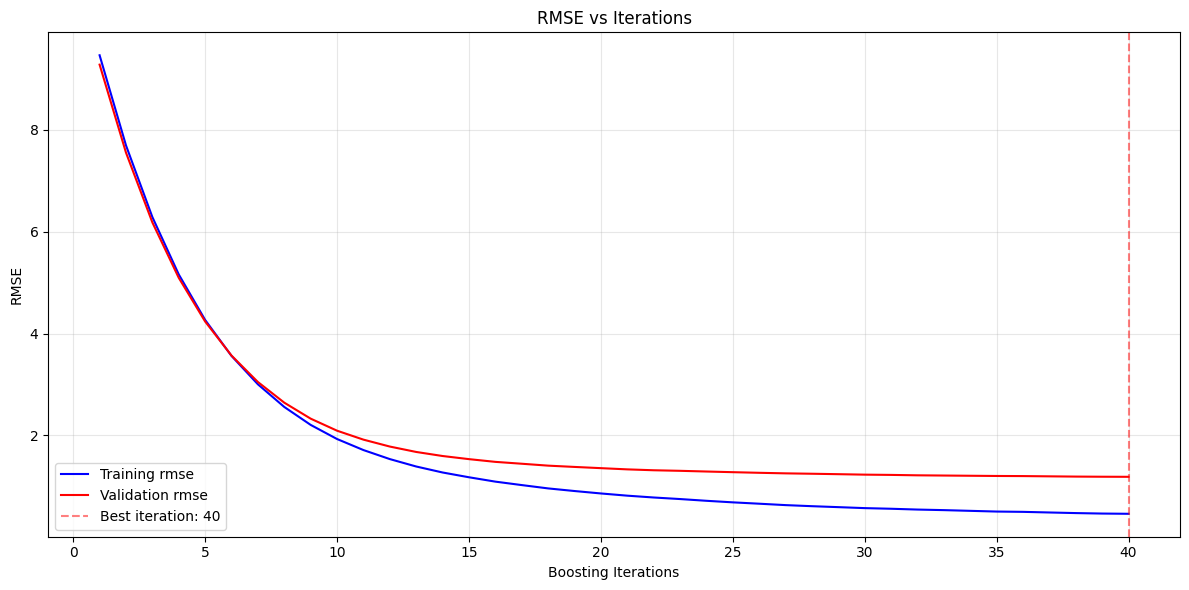


----- Advanced Learning Curve Analysis -----


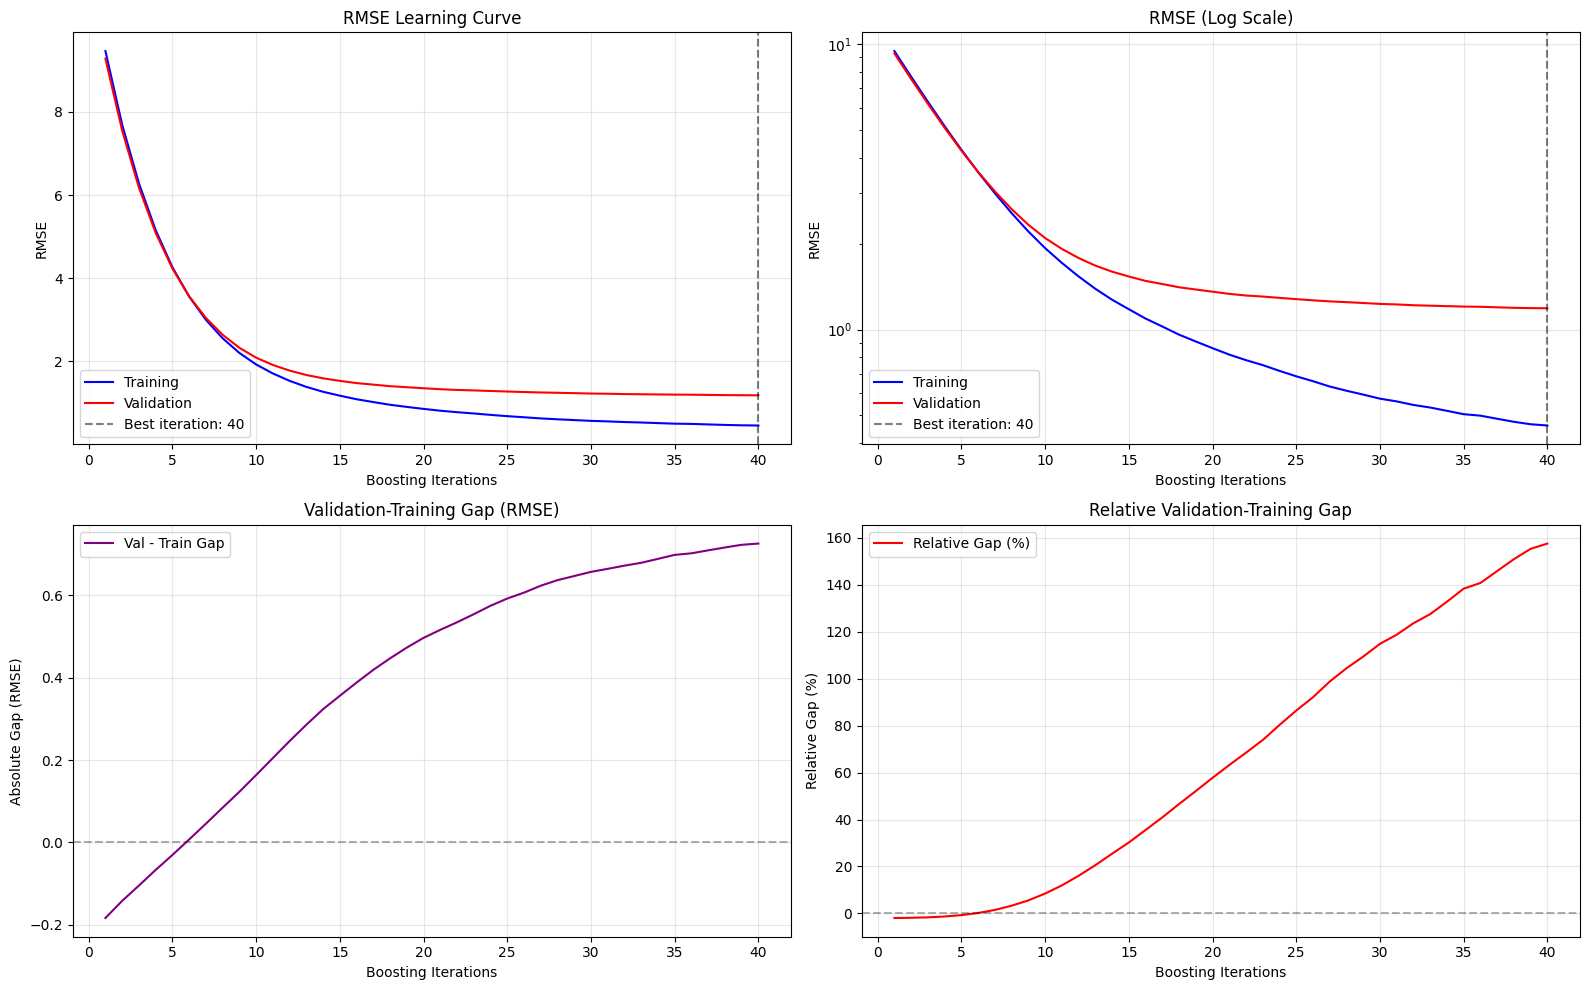


----- Feature Importance Analysis -----
Feature importances (gain):
 1. tmax_2m: 80.94%
 2. tmp_2m: 15.45%
 3. tmp_pres_925: 0.75%
 4. tmp_pres_700: 0.72%
 5. tmp_pres_850: 0.36%
 6. lhtfl_sfc: 0.22%
 7. ulwrf_sfc: 0.19%
 8. doy: 0.17%
 9. dswrf_sfc: 0.10%
10. dlwrf_sfc: 0.10%
11. soilw_bgrnd: 0.10%
12. ugrd_pres_700: 0.09%
13. vgrd_pres_700: 0.09%
14. shtfl_sfc: 0.08%
15. hgt_pres_700: 0.08%
16. ugrd_pres_850: 0.07%
17. uswrf_sfc: 0.07%
18. vgrd_hgt: 0.07%
19. pres_msl: 0.06%
20. ugrd_hgt: 0.06%
Computing SHAP values (this may take a while for large datasets)...
Using a sample of 1000 rows from 8594 for SHAP analysis


<ipython-input-10-2718665816>:157: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.68960840e+03 6.62911499e+02 4.48968506e+02 1.11405750e+03
 1.98224927e+03 4.02554906e+05 1.94360312e+04 9.32229492e+03
 1.88289336e+04 2.10897450e+06 1.61527454e+03 1.11374854e+03
 1.80518433e+03 2.29935327e+03 1.69518701e+03 7.59367676e+02
 1.33667725e+03 2.29928369e+03 2.60765771e+03 2.51191479e+03
 1.78611340e+03 5.00605713e+03 5.83401807e+03 2.02981409e+03
 2.48529688e+03 1.05242639e+03 4.32007373e+03]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_features.update(existing_features)


SHAP-based feature importances:
 1. tmax_2m: 55.50%
 2. tmp_2m: 21.14%
 3. tmp_pres_700: 3.67%
 4. tmp_pres_925: 3.00%
 5. lhtfl_sfc: 2.19%
 6. doy: 1.56%
 7. tmp_pres_850: 1.41%
 8. ulwrf_sfc: 1.31%
 9. dlwrf_sfc: 1.18%
10. dswrf_sfc: 1.17%
11. hgt_pres_700: 0.88%
12. soilw_bgrnd: 0.77%
13. ugrd_hgt: 0.70%
14. shtfl_sfc: 0.62%
15. vgrd_pres_700: 0.57%
16. ugrd_pres_850: 0.56%
17. uswrf_sfc: 0.52%
18. ugrd_pres_700: 0.49%
19. ugrd_pres_925: 0.43%
20. vgrd_hgt: 0.43%

----- Feature Selection using SHAP values -----
SHAP importance drop threshold (10th percentile): 0.23198
Keeping 24 features, Dropping 3 features
Dropped features:
  pres_sfc, vgrd_pres_925, hgt_pres_925

----- Feature Engineering: Creating Interaction Features -----
Creating interaction features from top 5 features: ['tmax_2m', 'tmp_2m', 'tmp_pres_700', 'tmp_pres_925', 'lhtfl_sfc']
Added 10 interaction features
Creating interaction features from top 5 features: ['tmax_2m', 'tmp_2m', 'tmp_pres_700', 'tmp_pres_925', 'lhtfl

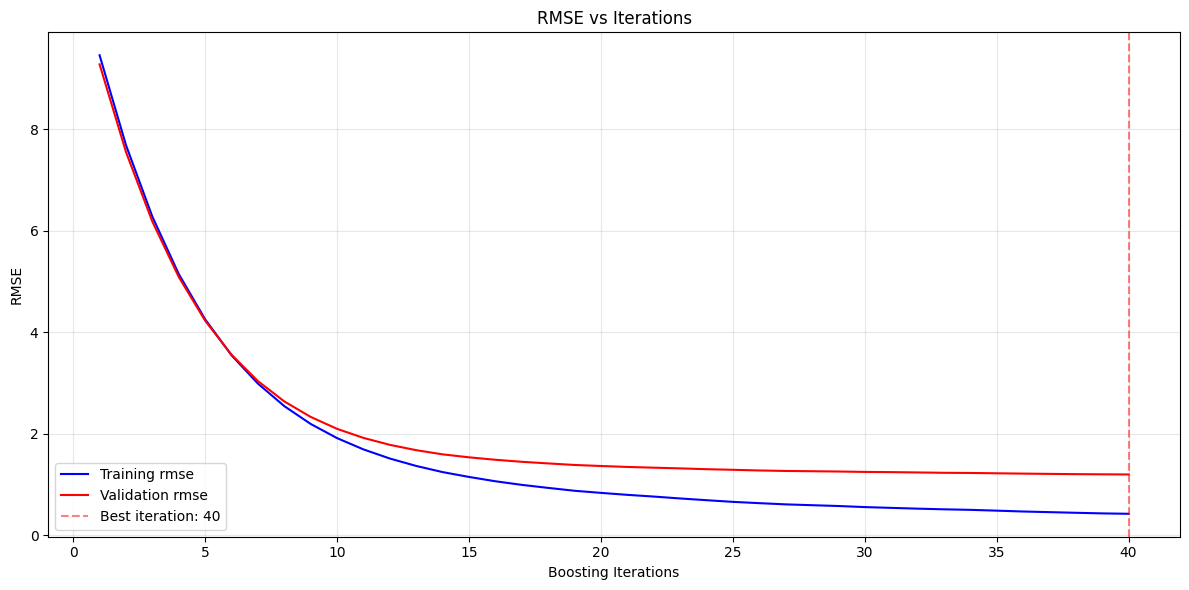


----- Final Model Learning Curve Analysis -----


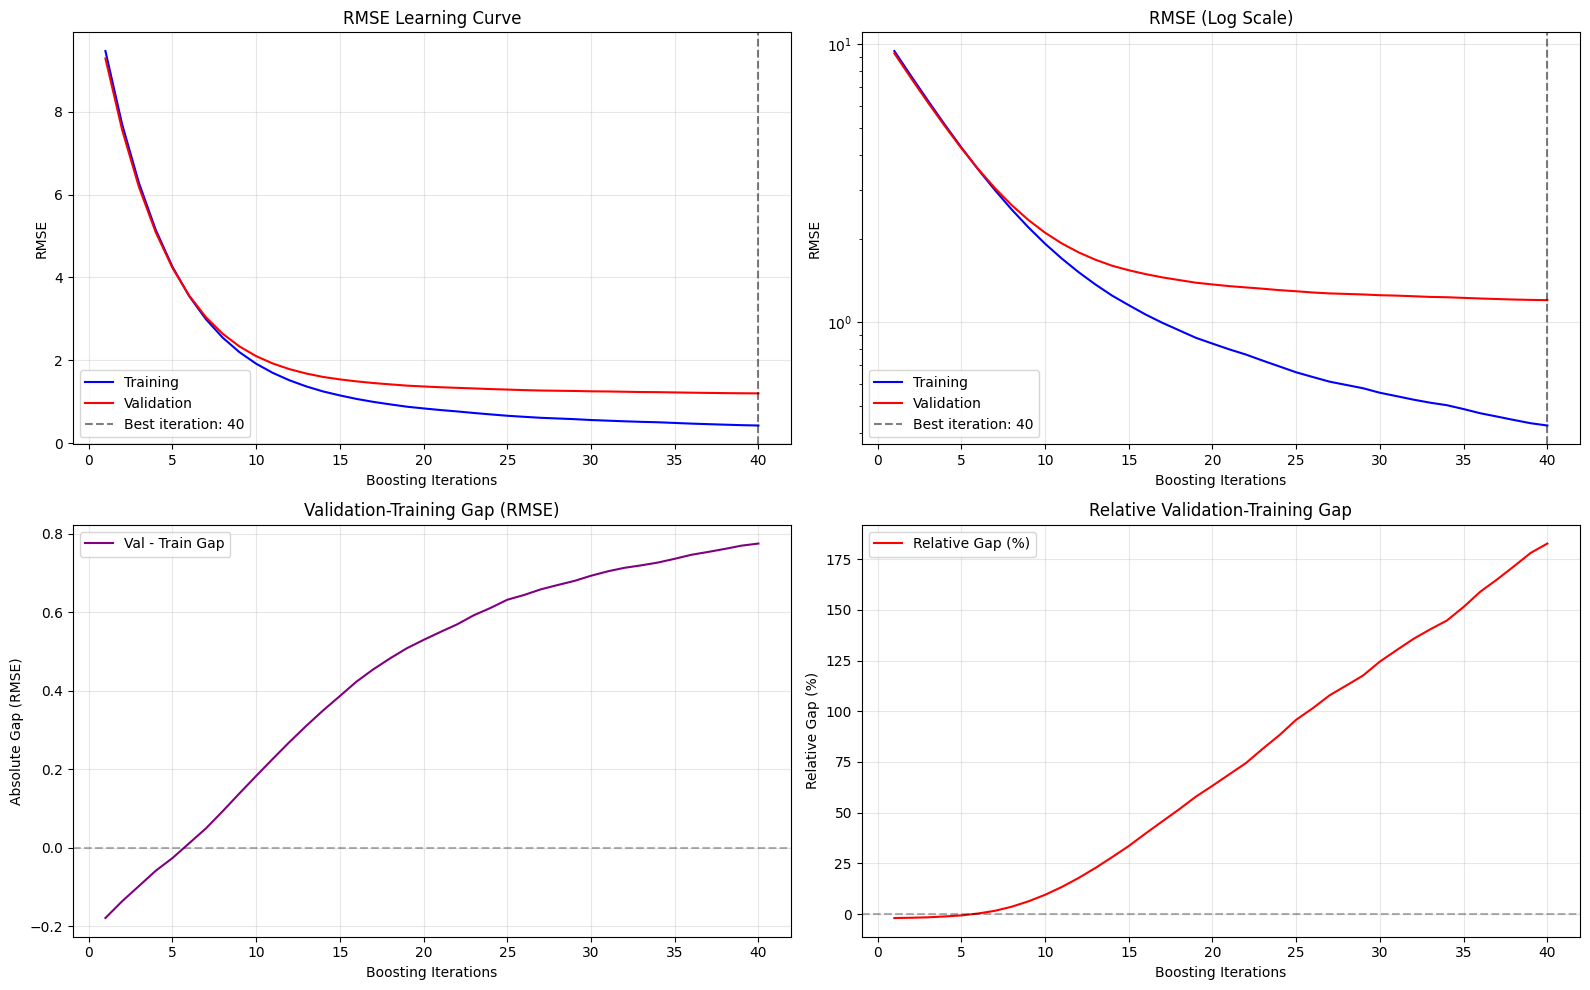

Feature importances (gain):
 1. tmax_2m_x_tmp_2m: 52.82%
 2. tmax_2m: 28.81%
 3. tmp_2m: 9.75%
 4. tmax_2m_x_tmp_pres_925: 2.74%
 5. tmp_pres_700_x_lhtfl_sfc: 1.31%
 6. tmp_pres_925: 1.11%
 7. tmp_2m_x_lhtfl_sfc: 0.59%
 8. tmp_pres_925_x_lhtfl_sfc: 0.45%
 9. tmp_2m_x_tmp_pres_700: 0.39%
10. tmp_pres_850: 0.16%
11. doy: 0.15%
12. tmax_2m_x_tmp_pres_700: 0.14%
13. tmp_pres_700: 0.11%
14. tmax_2m_x_lhtfl_sfc: 0.11%
15. lhtfl_sfc: 0.10%
16. ulwrf_sfc: 0.10%
17. ugrd_pres_700: 0.09%
18. soilw_bgrnd: 0.09%
19. dlwrf_sfc: 0.09%
20. hgt_pres_700: 0.08%
Computing SHAP values (this may take a while for large datasets)...
Using a sample of 1000 rows from 8594 for SHAP analysis


<ipython-input-10-2718665816>:157: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7.50803125e+05 2.53960281e+05 2.90131909e+03 2.90105684e+04
 2.61731323e+03 3.83596680e+03 4.27016699e+03 2.57355249e+03
 2.21981055e+03 1.82042542e+03 2.10829688e+03 2.26107397e+03
 1.62702112e+03 1.65133154e+03 1.98053955e+03 2.08994995e+03
 1.67013635e+03 2.36571240e+03 9.65458679e+02 1.57178577e+03
 9.19516357e+02 1.24991235e+03 1.68775659e+03 1.30809155e+03
 1.37642212e+06 3.59354883e+03 7.13003281e+04 2.86738525e+03
 1.02423799e+04 1.29883044e+03 1.52845244e+04 1.76019434e+03
 3.40889766e+04 1.16334619e+04]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_features.update(existing_features)


SHAP-based feature importances:
 1. tmax_2m_x_tmp_2m: 32.26%
 2. tmax_2m: 24.35%
 3. tmp_2m: 10.44%
 4. tmax_2m_x_tmp_pres_925: 4.25%
 5. tmp_pres_700_x_lhtfl_sfc: 3.85%
 6. tmp_pres_925: 3.39%
 7. tmp_2m_x_lhtfl_sfc: 3.01%
 8. tmp_pres_925_x_lhtfl_sfc: 1.49%
 9. tmp_pres_850: 1.27%
10. doy: 1.25%
11. tmp_2m_x_tmp_pres_700: 1.21%
12. dlwrf_sfc: 0.87%
13. ulwrf_sfc: 0.87%
14. hgt_pres_700: 0.86%
15. soilw_bgrnd: 0.83%
16. tmax_2m_x_tmp_pres_700: 0.78%
17. dswrf_sfc: 0.77%
18. tmp_pres_700: 0.71%
19. lhtfl_sfc: 0.65%
20. tmp_pres_700_x_tmp_pres_925: 0.65%

----- Cross-validation with Feature Engineering -----
Running 5 CV folds in parallel with 5 jobs

----- Generating Final Predictions -----

----- Final Model Evaluation -----
Validation R2:   0.9890
Validation MAE:  0.8579
Validation RMSE: 1.1999
Test R2:   0.9895
Test MAE:  0.8453
Test RMSE: 1.1876

----- Creating Diagnostic Visualizations -----


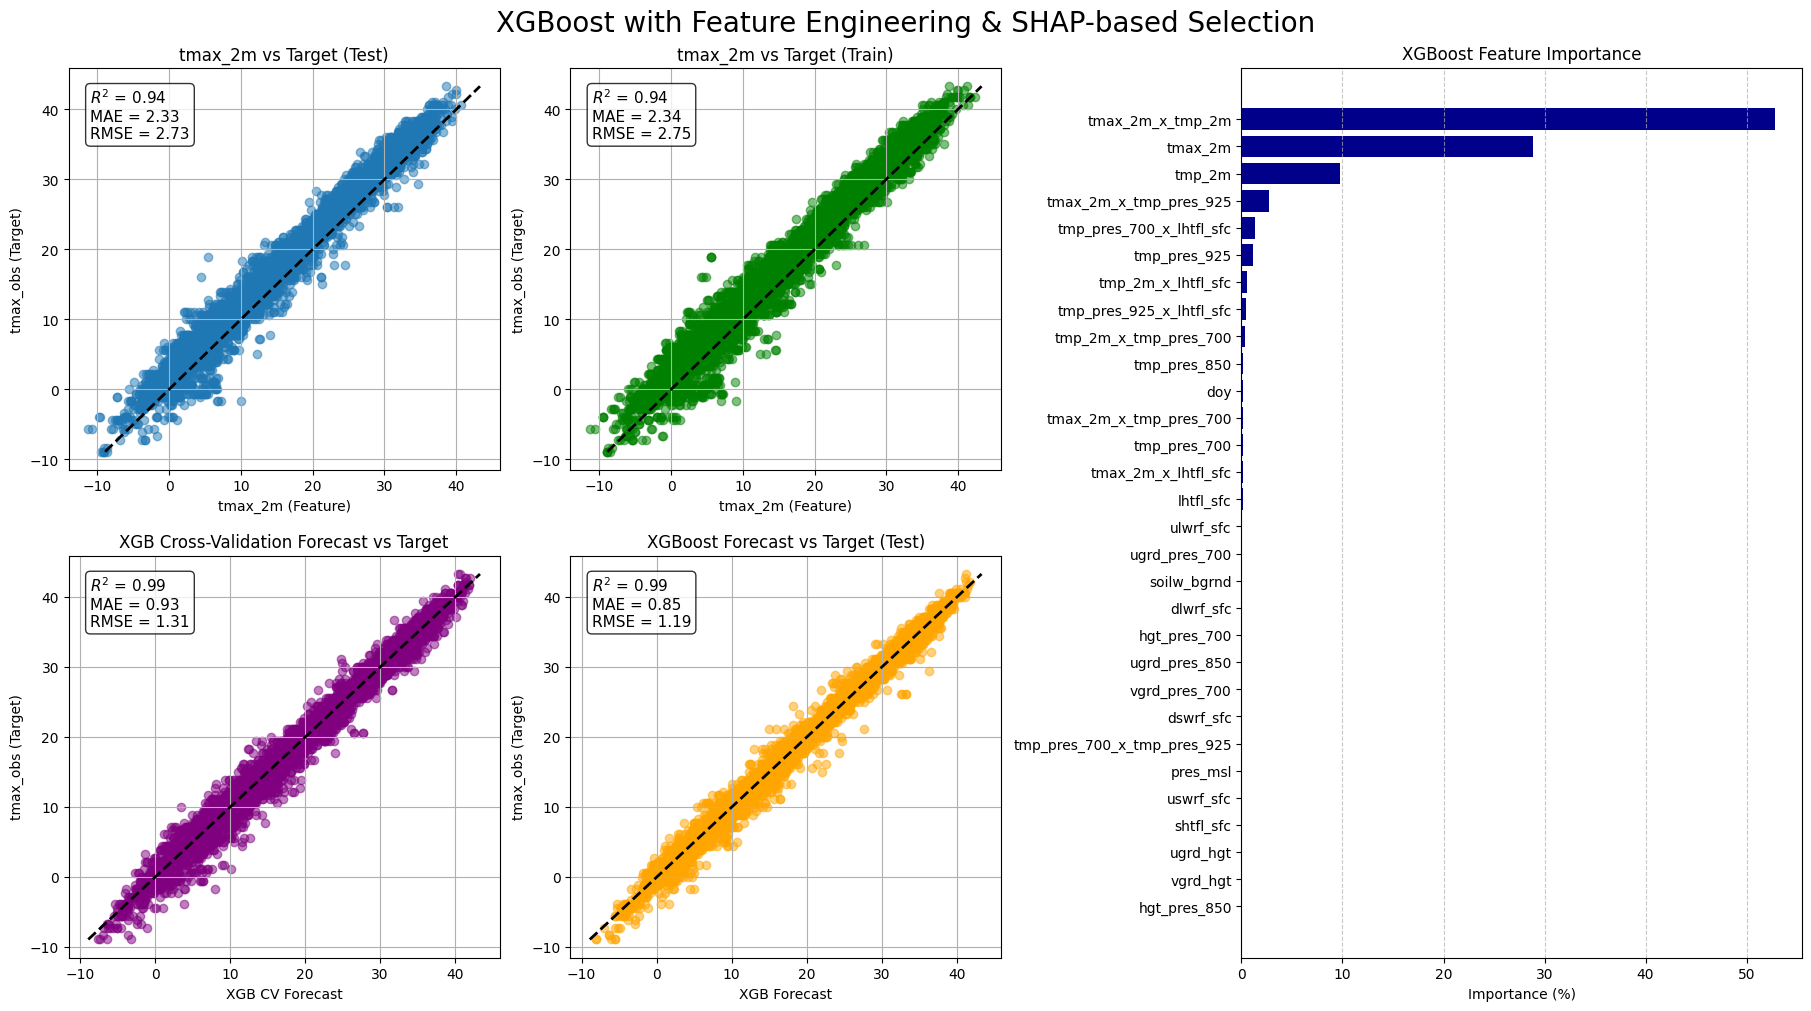

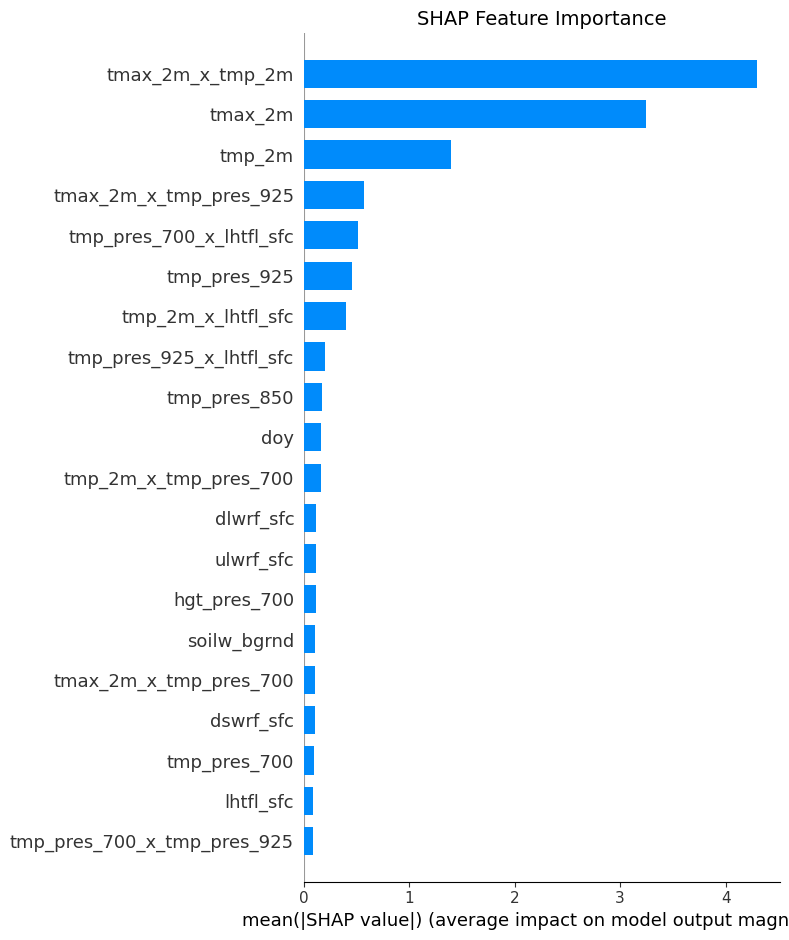

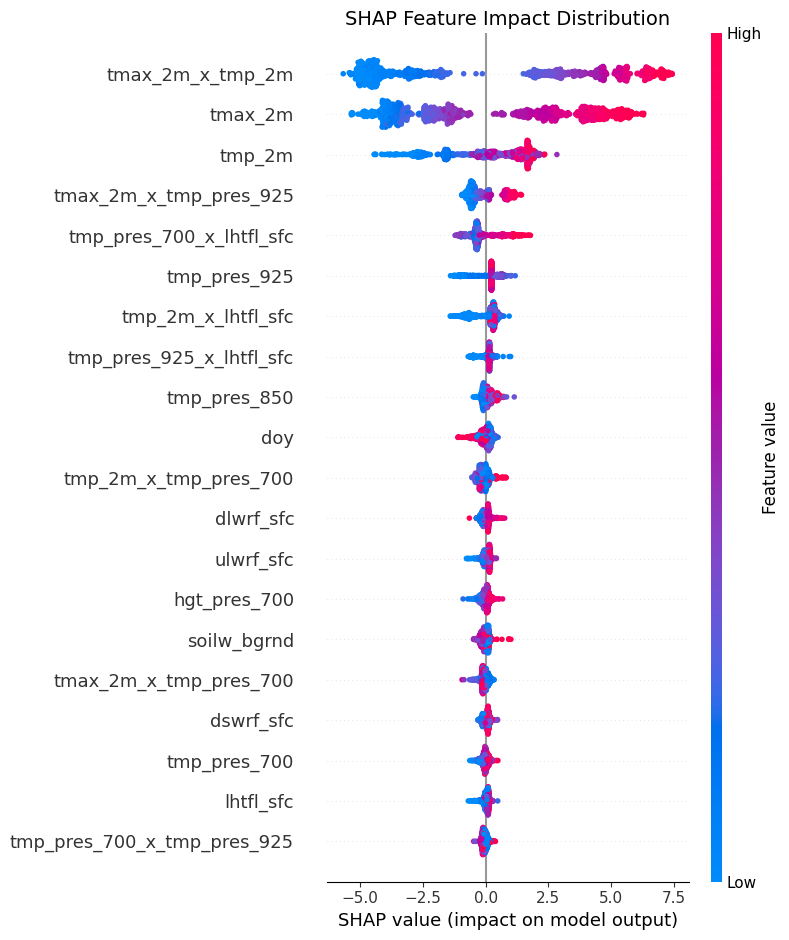

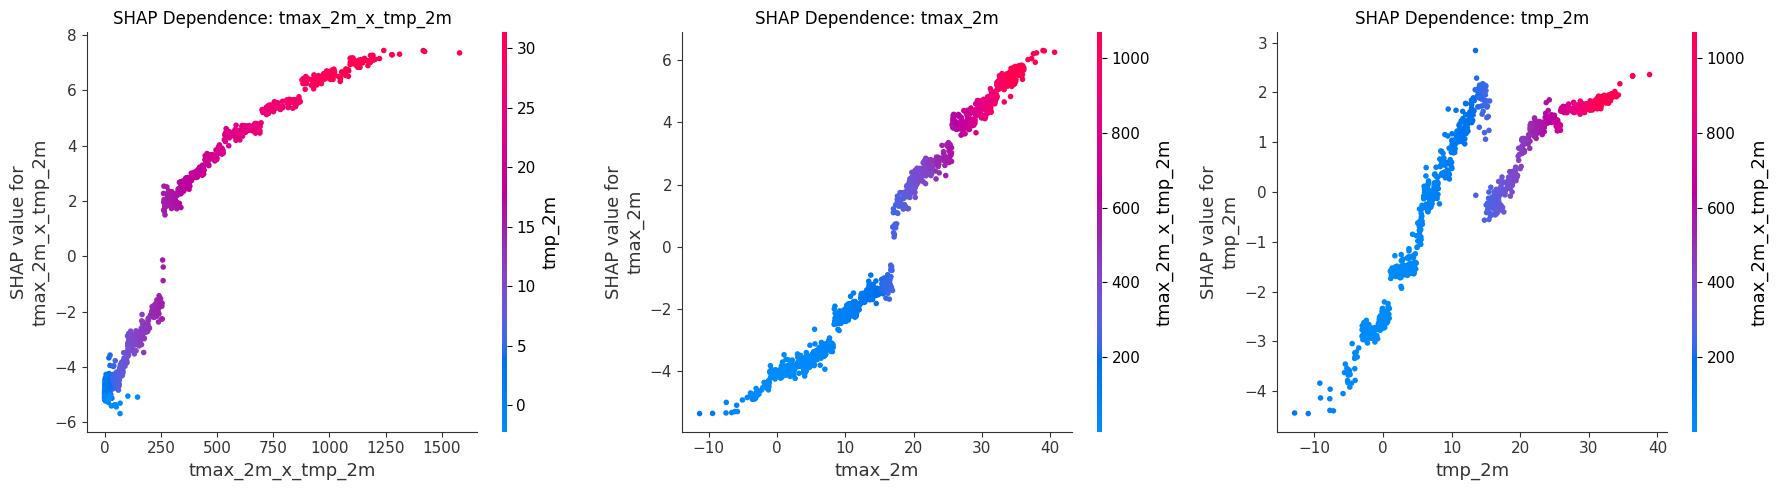

<Figure size 1400x300 with 0 Axes>

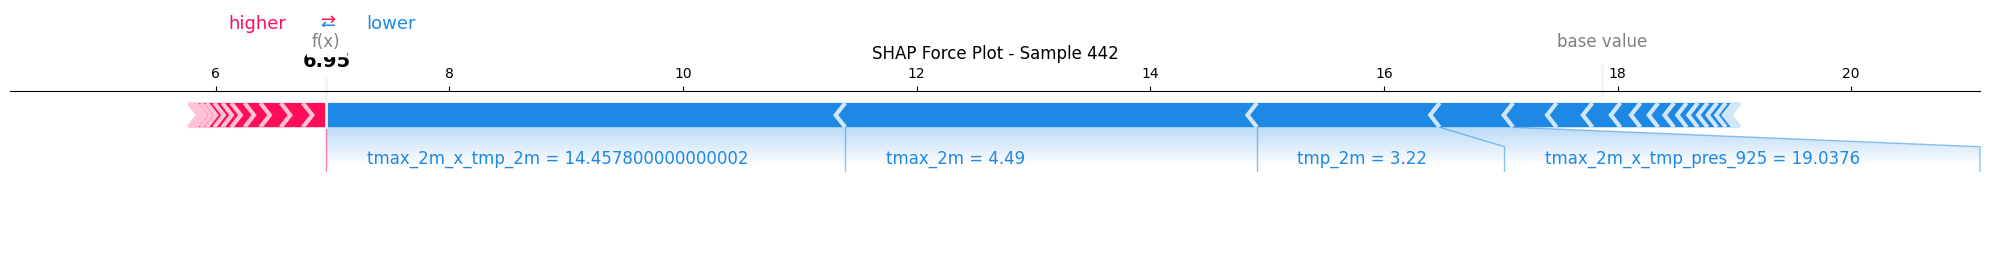

<Figure size 1400x300 with 0 Axes>

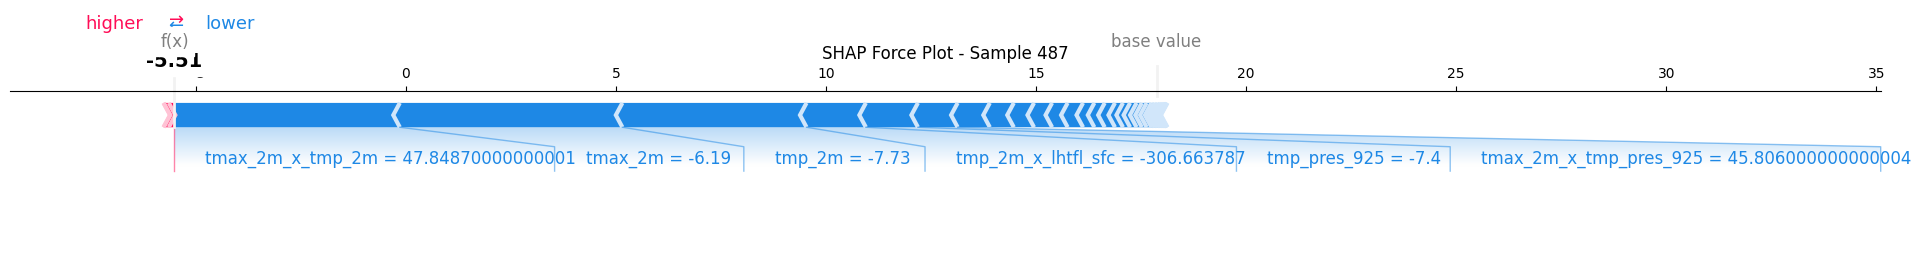

<Figure size 1400x300 with 0 Axes>

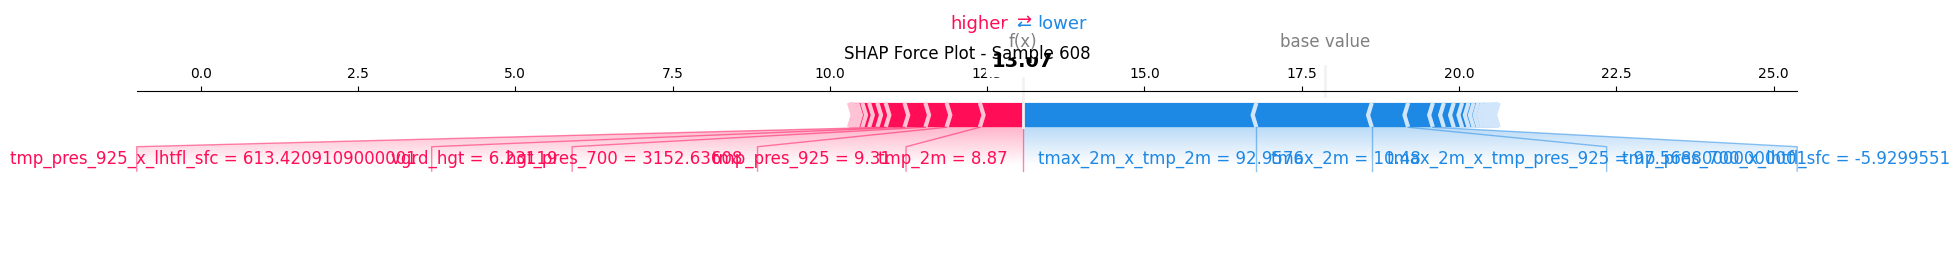


Total execution time: 20.92 seconds

Best model test RMSE: 1.1876
Best model test R²: 0.9895


In [ ]:
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Run the improved XGBoost pipeline
# Using 5 CPU cores for parallel processing
results = xgb_gridsearch_pipeline(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    debug=False,  # Set to True for a quick test run
    max_fits=5,  # Number of hyperparameter combinations to try
    n_folds=5,    # Number of CV folds
    n_jobs=5      # Parallel processing
)

# Access the best model and other results
best_model = results["best_model"]
best_params = results["best_params"]
test_stats = results["test_stats"]

print(f"\nBest model test RMSE: {test_stats['rmse']:.4f}")
print(f"Best model test R²: {test_stats['r2']:.4f}")

Created feature: doy
Created interaction feature: tmax_2m_x_tmp_2m = tmax_2m * tmp_2m
Created interaction feature: tmax_2m_x_tmp_pres_700 = tmax_2m * tmp_pres_700
Created interaction feature: tmax_2m_x_tmp_pres_925 = tmax_2m * tmp_pres_925
Created interaction feature: tmax_2m_x_lhtfl_sfc = tmax_2m * lhtfl_sfc
Created interaction feature: tmp_2m_x_tmp_pres_700 = tmp_2m * tmp_pres_700
Created interaction feature: tmp_2m_x_tmp_pres_925 = tmp_2m * tmp_pres_925
Created interaction feature: tmp_2m_x_lhtfl_sfc = tmp_2m * lhtfl_sfc
Created interaction feature: tmp_pres_700_x_tmp_pres_925 = tmp_pres_700 * tmp_pres_925
Created interaction feature: tmp_pres_700_x_lhtfl_sfc = tmp_pres_700 * lhtfl_sfc
Created interaction feature: tmp_pres_925_x_lhtfl_sfc = tmp_pres_925 * lhtfl_sfc
Total interaction features created: 10
Created interaction feature: tmax_2m_x_tmp_2m = tmax_2m * tmp_2m
Created interaction feature: tmax_2m_x_tmp_pres_700 = tmax_2m * tmp_pres_700
Created interaction feature: tmax_2m_x_t

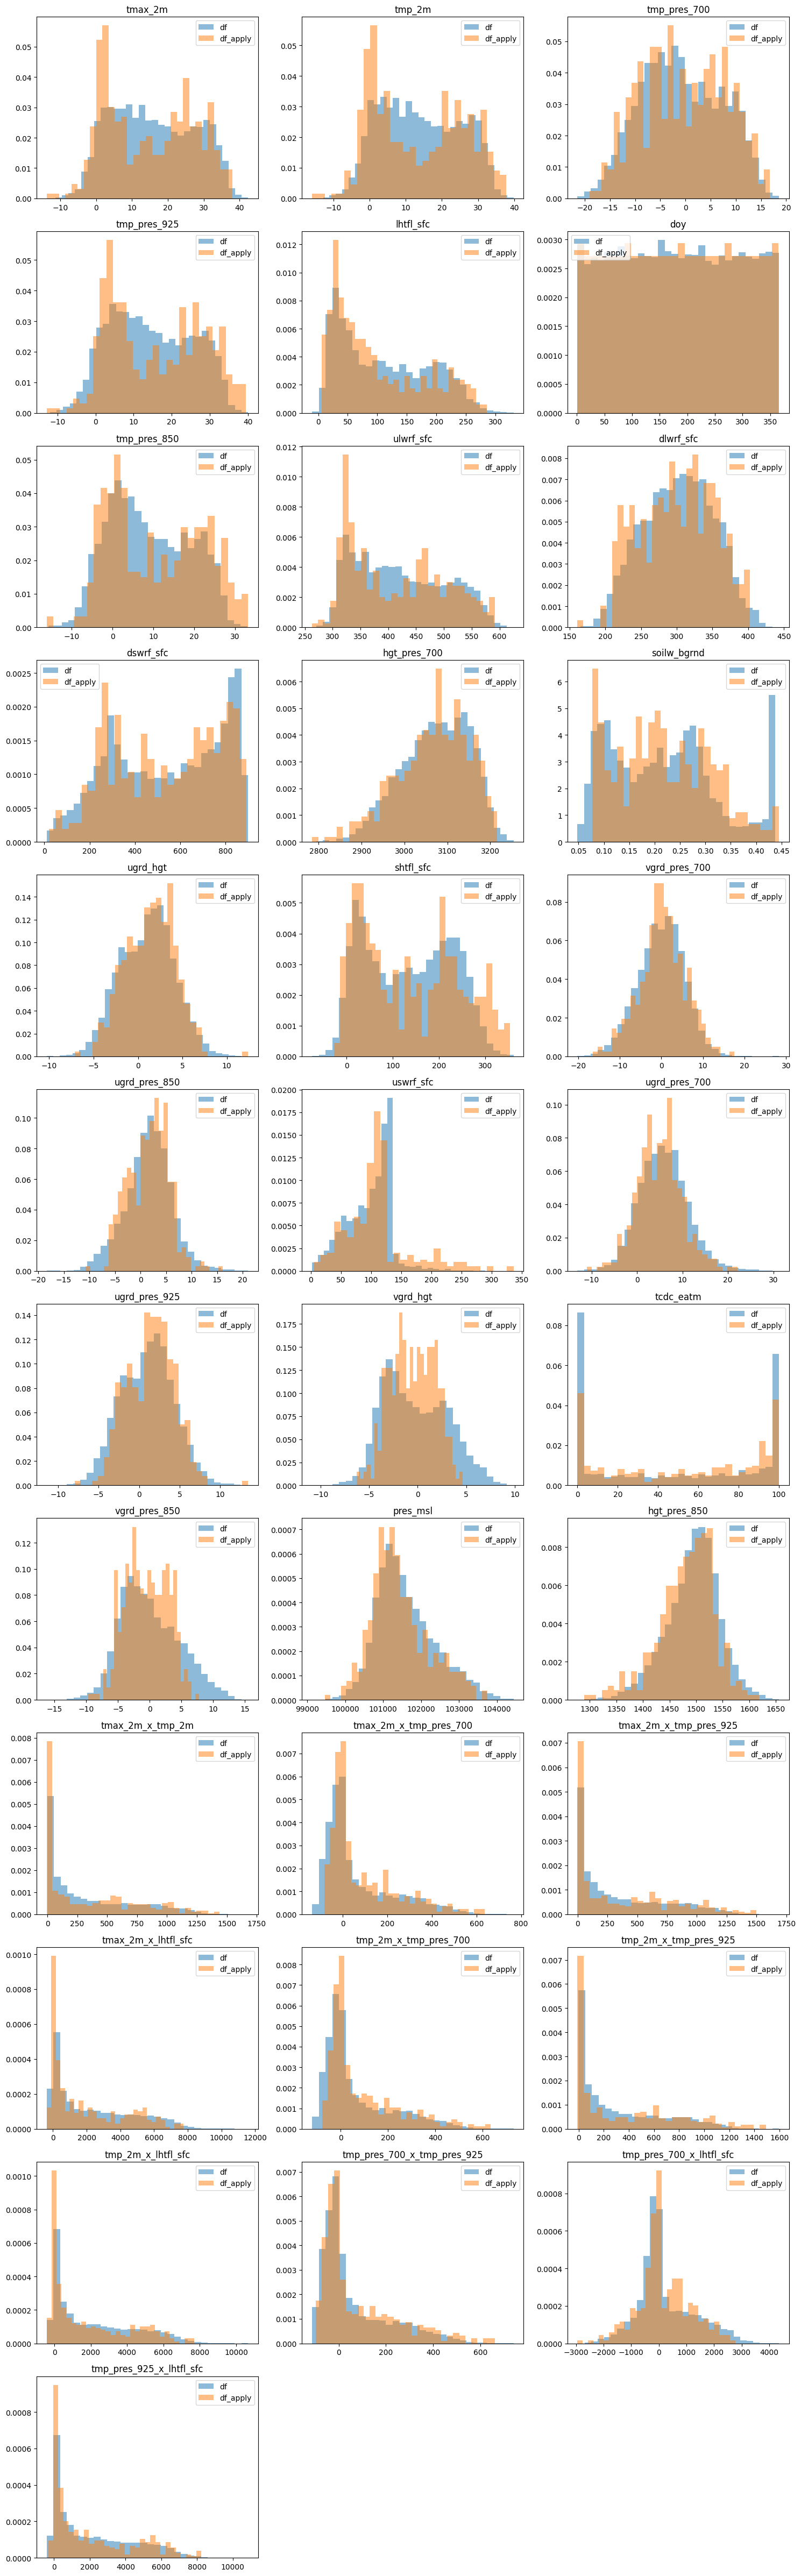

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load Data ---
nbm = pd.read_csv('/content/KBOI_2023_2024_f024.nbm.csv')
gefs = pd.read_csv('/content/KBOI_2023_2023_f024.forecast.csv')
features = results['selected_features']

# --- Load Results and Feature List ---
# results = pickle.load(open("results.pkl", "rb"))
# features = results['selected_features']
# For illustration:
# features = ["tmax_2m", "tmin_2m", "doy", "tmax_2m_x_tmin_2m", ...]

def create_interactions_from_features(X, features, verbose=True):
    """
    For every feature in features containing '_x_', create it as the product of its component features.
    Only creates if both components are present in X.
    Prints each feature as it is created if verbose=True.
    """
    X_enhanced = X.copy()
    created_features = []
    for feat in features:
        if "_x_" in feat:
            f1, f2 = feat.split("_x_")
            if f1 in X_enhanced.columns and f2 in X_enhanced.columns:
                X_enhanced[feat] = X_enhanced[f1] * X_enhanced[f2]
                created_features.append(feat)
                if verbose:
                    print(f"Created interaction feature: {feat} = {f1} * {f2}")
    if verbose and created_features:
        print(f"Total interaction features created: {len(created_features)}")
    return X_enhanced

# --- Feature Engineering on gefs (application data) ---
gefs['doy'] = pd.to_datetime(gefs['valid_datetime']).dt.dayofyear
print("Created feature: doy")
gefs = create_interactions_from_features(gefs, features, verbose=True)
df = create_interactions_from_features(df, features, verbose=True)
gefs.set_index('valid_datetime', inplace=True)
df_apply = gefs[~np.isnan(gefs['tmax_2m'])]

# --- Check for Missing Features ---
missing_apply = [f for f in features if f not in df_apply.columns]
if missing_apply:
    print("Missing engineered features in df_apply:", missing_apply)
    # Optionally, raise an error or add logic to create missing features

missing_df = [f for f in features if f not in df.columns]
if missing_df:
    print("Missing engineered features in df:", missing_df)
    # Optionally, raise an error or add logic to create missing features

# --- Plotting Distributions ---
n_features = len(features)
ncols = 3
nrows = (n_features + ncols - 1) // ncols

plt.figure(figsize=(5 * ncols, 4 * nrows))
for i, feature in enumerate(features):
    plt.subplot(nrows, ncols, i + 1)
    # Overlay histograms for both datasets if feature is present
    if feature in df.columns:
        data_df = df[feature].dropna()
        if len(data_df) > 0:
            plt.hist(data_df, bins=30, alpha=0.5, label='df', color='tab:blue', density=True)
    if feature in df_apply.columns:
        data_apply = df_apply[feature].dropna()
        if len(data_apply) > 0:
            plt.hist(data_apply, bins=30, alpha=0.5, label='df_apply', color='tab:orange', density=True)
    plt.title(feature)
    plt.legend(loc='best')
plt.tight_layout()
plt.show()

Created interaction feature: tmax_2m_x_tmp_2m = tmax_2m * tmp_2m
Created interaction feature: tmax_2m_x_tmp_pres_700 = tmax_2m * tmp_pres_700
Created interaction feature: tmax_2m_x_tmp_pres_925 = tmax_2m * tmp_pres_925
Created interaction feature: tmax_2m_x_lhtfl_sfc = tmax_2m * lhtfl_sfc
Created interaction feature: tmp_2m_x_tmp_pres_700 = tmp_2m * tmp_pres_700
Created interaction feature: tmp_2m_x_tmp_pres_925 = tmp_2m * tmp_pres_925
Created interaction feature: tmp_2m_x_lhtfl_sfc = tmp_2m * lhtfl_sfc
Created interaction feature: tmp_pres_700_x_tmp_pres_925 = tmp_pres_700 * tmp_pres_925
Created interaction feature: tmp_pres_700_x_lhtfl_sfc = tmp_pres_700 * lhtfl_sfc
Created interaction feature: tmp_pres_925_x_lhtfl_sfc = tmp_pres_925 * lhtfl_sfc
Total interaction features created: 10


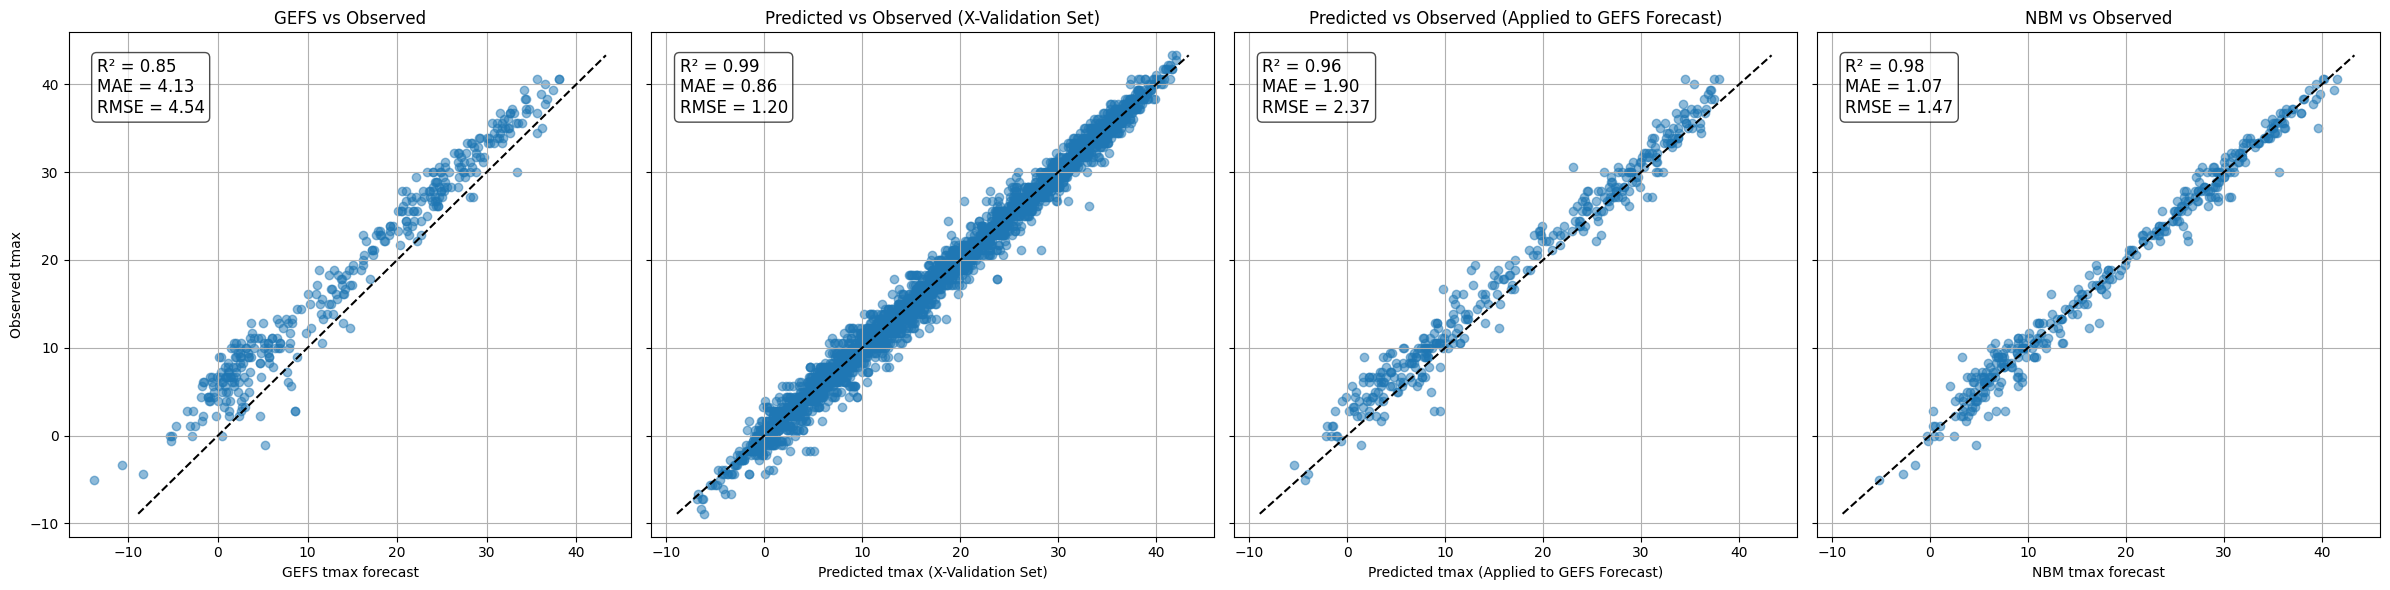

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Prepare the data for each panel
x_gefs = df_apply['tmax_2m']
x_model_apply = results['best_model'].predict(df_apply[results['selected_features']])
x_nbm = nbm.set_index('valid_datetime').loc[df_apply.index]['tmax_2m']
y_obs_apply = df_apply['tmax_obs']

# For the validation panel, use X_val/y_val for validation
X_val = create_interactions_from_features(X_val, features, verbose=True)
x_model_val = results['best_model'].predict(X_val[features])
y_obs_val = y_val

# For the actual apply panel (Model Prediction vs Observed on APPLY/TEST)
x_model_apply_panel = x_model_apply  # This is already predicted above

# Mask to keep only entries where y_obs is not NaN
mask_apply = ~np.isnan(y_obs_apply)
x_gefs = x_gefs[mask_apply]
x_model_apply = x_model_apply[mask_apply]
x_nbm = x_nbm[mask_apply]
y_obs_apply = y_obs_apply[mask_apply]

mask_val = ~np.isnan(y_obs_val)
x_model_val = x_model_val[mask_val]
y_obs_val = y_obs_val[mask_val]

min_y = min(y_obs_apply.min(), y_obs_val.min())
max_y = max(y_obs_apply.max(), y_obs_val.max())

def metrics_text(x, y):
    # Remove any NaNs in x (in case)
    x, y = np.array(x), np.array(y)
    mask = ~np.isnan(x)
    x = x[mask]
    y = y[mask]
    if len(x) == 0 or len(y) == 0:
        return "R² = N/A\nMAE = N/A\nRMSE = N/A"
    r2 = r2_score(y, x)
    rmse = np.sqrt(mean_squared_error(y, x))
    mae = mean_absolute_error(y, x)
    return f"R² = {r2:.2f}\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}"

fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=True)

# Panel 1: Raw GEFS vs Observed (APPLY/TEST)
axes[0].scatter(x_gefs, y_obs_apply, alpha=0.5)
axes[0].plot([min_y, max_y], [min_y, max_y], 'k--')
axes[0].set_xlabel('GEFS tmax forecast')
axes[0].set_ylabel('Observed tmax')
axes[0].set_title('GEFS vs Observed')
axes[0].text(0.05, 0.95, metrics_text(x_gefs, y_obs_apply), transform=axes[0].transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

# Panel 2: Model Prediction vs Observed (VALIDATION)
axes[1].scatter(x_model_val, y_obs_val, alpha=0.5)
axes[1].plot([min_y, max_y], [min_y, max_y], 'k--')
axes[1].set_xlabel('Predicted tmax (X-Validation Set)')
axes[1].set_title('Predicted vs Observed (X-Validation Set)')
axes[1].text(0.05, 0.95, metrics_text(x_model_val, y_obs_val), transform=axes[1].transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

# Panel 3: Model Prediction vs Observed (APPLY/TEST)
axes[2].scatter(x_model_apply, y_obs_apply, alpha=0.5)
axes[2].plot([min_y, max_y], [min_y, max_y], 'k--')
axes[2].set_xlabel('Predicted tmax (Applied to GEFS Forecast)')
axes[2].set_title('Predicted vs Observed (Applied to GEFS Forecast)')
axes[2].text(0.05, 0.95, metrics_text(x_model_apply, y_obs_apply), transform=axes[2].transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

# Panel 4: NBM vs Observed (APPLY/TEST)
axes[3].scatter(x_nbm, y_obs_apply, alpha=0.5)
axes[3].plot([min_y, max_y], [min_y, max_y], 'k--')
axes[3].set_xlabel('NBM tmax forecast')
axes[3].set_title('NBM vs Observed')
axes[3].text(0.05, 0.95, metrics_text(x_nbm, y_obs_apply), transform=axes[3].transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

for ax in axes:
    ax.grid(True)

plt.tight_layout()
plt.show()